# H1V2 SQUAT

The idea is to do a squat movement with h1v2. This time, I will not use a given trajectory, but will try to define one by myself.
I first plan to give a trajectory to the center of mass. 

In [9]:
# import robot_loader from scripts
import pinocchio as pin
import crocoddyl
import os
import numpy as np
from scripts.robot_loader import *
import meshcat.geometry as mg

# load model on Meshcat
model, collision_model, visual_model, robot_visualizer, viz = launch_visualization()

print(f"--- Pinocchio model datas ---")
print(f"Robot name: {model.name}")
print(f"Configuration dimension (nq): {model.nq}")
print(f"Velocity dimension (nv): {model.nv}")

data = model.createData()
robot_visualizer.data = data

# Display some frames
frames_to_display = ["pelvis", "left_ground", "right_ground"]
frame_ids = [model.getFrameId(frame_name) for frame_name in frames_to_display]
robot_visualizer.displayFrames(True, frame_ids)

# Display the robot on in initial position, with his feets close to the ground
q0 = pin.neutral(model)
q0[2] = 1.03
robot_visualizer.display(q0)
pin.forwardKinematics(model, data, q0)
pin.updateFramePlacements(model, data)

--- Searching for robot paths ---
Detected project root directory: /home/cpene/Documents/robot_playground
Asset paths verified.
Detected urdf file: /home/cpene/Documents/robot_playground/robot_models/h1_2_description/h1_2_handless.urdf
Detected mesh directory: /home/cpene/Documents/robot_playground/robot_models/h1_2_description
Launching MeshCat...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
Adding a grid to represent the ground.
Loading robot model into Pinocchio...
Pinocchio model loaded successfully.
Frame 'left_ground' added successfully.
Frame 'right_ground' added successfully.

Environment is ready !
--- Pinocchio model datas ---
Robot name: h1_2
Configuration dimension (nq): 34
Velocity dimension (nv): 33


In [10]:
# Initialisation of OCP problem
from ocp.ocp_builder import OCPBuilder
from ocp.cost_manager import CostModelManager
from ocp.contact_manager import ContactModelManager


v0 = np.zeros(model.nv)
x0 = np.concatenate([q0, v0])

TIME_STEP = 0.01
HORIZON_LENGTH = 100

# initiate OCP
ocp_build = OCPBuilder(initial_state=x0,
                                 rmodel=model,
                                 dt=TIME_STEP,
                                 horizon_length=HORIZON_LENGTH)

# I want the robot to go down, forcing it to perform a squat
x_final = x0.copy()
x_final[2] -= 0.5 # movement toward z axes

In [11]:
# create contacts

running_contact_managers = []
for i in range (HORIZON_LENGTH):
    contact_manager_i = ContactModelManager(ocp_build.state, ocp_build.actuation, model, data)
    contact_manager_i.add_contact_6D("left_ground") \
                     .add_contact_6D("right_ground")
    running_contact_managers.append(contact_manager_i)

terminal_contact_manager = ContactModelManager(ocp_build.state, ocp_build.actuation, model, data) \
        .add_contact_6D("left_ground") \
        .add_contact_6D("right_ground")

# DEBUG
terminal_contact_manager.display_contacts()

---- Contact Model Summary ----
  Total number of contacts: 2
---------------------------
  > Contact Name: '<bound method key of (left_ground_contact, {ContactModel6D {frame=left_ground, type=1}})>'
    - Type      : ContactModel6D
    - Frame Name: 'left_ground' (ID: 65)
  > Contact Name: '<bound method key of (right_ground_contact, {ContactModel6D {frame=right_ground, type=1}})>'
    - Type      : ContactModel6D
    - Frame Name: 'right_ground' (ID: 66)
---------------------------



In [12]:
# create costs
left_foot_id = model.getFrameId("left_ground")
right_foot_id = model.getFrameId("right_ground")
contact_frame_ids = [left_foot_id, right_foot_id]

running_cost_managers = []

for i in range (HORIZON_LENGTH):

    # create a kind of trajectory
    alpha = float(i + 1) / HORIZON_LENGTH
    x_ref_i = (1 - alpha) * x0 + alpha * x_final
    
    cost_manager_i = CostModelManager(ocp_build.state, ocp_build.actuation)
    cost_manager_i.add_regulation_state_cost(x_ref_i, 0.1) \
                  .add_regulation_control_cost(0.01) \
                  .add_contact_friction_cone_cost(contact_frame_ids, 0.7, 200.0)

    running_cost_managers.append(cost_manager_i)
    
terminal_cost_manager = CostModelManager(ocp_build.state, ocp_build.actuation)
terminal_cost_manager.add_regulation_state_cost(x_final, 10.0) \
                     .add_contact_friction_cone_cost(contact_frame_ids, 0.7, 200.0)

# DEBUG
terminal_cost_manager.display_costs()


---- Cost Model Summary ----
  Total number of costs: 3
--------------------------
  > Cost Name: '<bound method key of (contact_friction_65, {w=200, CostModelResidual {ResidualModelContactFrictionCone {frame=left_ground, mu=0.7}, ActivationModelQuad {nr=5}}})>'
    - Weight: 200.0
    - Type  : CostModelResidual
  > Cost Name: '<bound method key of (contact_friction_66, {w=200, CostModelResidual {ResidualModelContactFrictionCone {frame=right_ground, mu=0.7}, ActivationModelQuad {nr=5}}})>'
    - Weight: 200.0
    - Type  : CostModelResidual
  > Cost Name: '<bound method key of (regulation_state, {w=10, CostModelResidual {ResidualModelState, ActivationModelQuad {nr=66}}})>'
    - Weight: 10.0
    - Type  : CostModelResidual
--------------------------



In [13]:
# finalize OCP
problem = ocp_build.build(running_cost_managers, terminal_cost_manager, running_contact_managers, terminal_contact_manager)

#print("OCP problem is ready")

In [14]:
# Create FDDP solver
solver = crocoddyl.SolverFDDP(problem)

solver.setCallbacks([
    crocoddyl.CallbackLogger(),
    #crocoddyl.CallbackVerbose()
])

# Create an initial guess 
# we are looking at a problem with HORIZON_LENGTH + 1 states and HORIZON_LENGTH commands
xs_init = []
for i in range(HORIZON_LENGTH + 1):
    xs_init.append(x0)
print(f"xs_init dimension : {len(xs_init)}")

v_zero = np.zeros(model.nv)
a_zero = np.zeros(model.nv)
full_gravity_torques = pin.rnea(model, data, q0, v_zero, a_zero)
actuated_gravity_torques = full_gravity_torques[6:]

us_init = [actuated_gravity_torques] * HORIZON_LENGTH
print(f"us_init dimension : {len(us_init)}")


MAX_ITER = 2000  # max iteration
converged = solver.solve(xs_init, us_init, MAX_ITER)


# Results analysis
if converged:
    print("SUCCESS: FDDP converged.")
else:
    print("FAILURE: FDDP did not converge.")

xs_init dimension : 101
us_init dimension : 100
SUCCESS: FDDP converged.


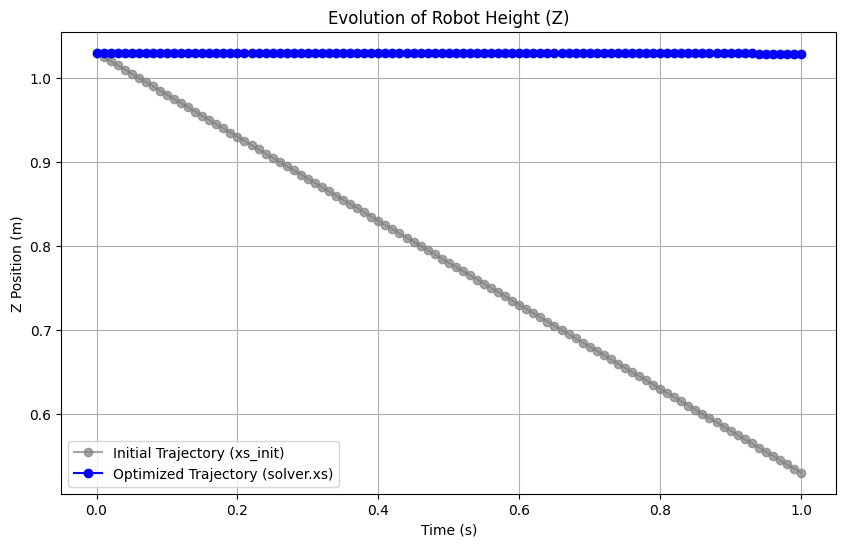

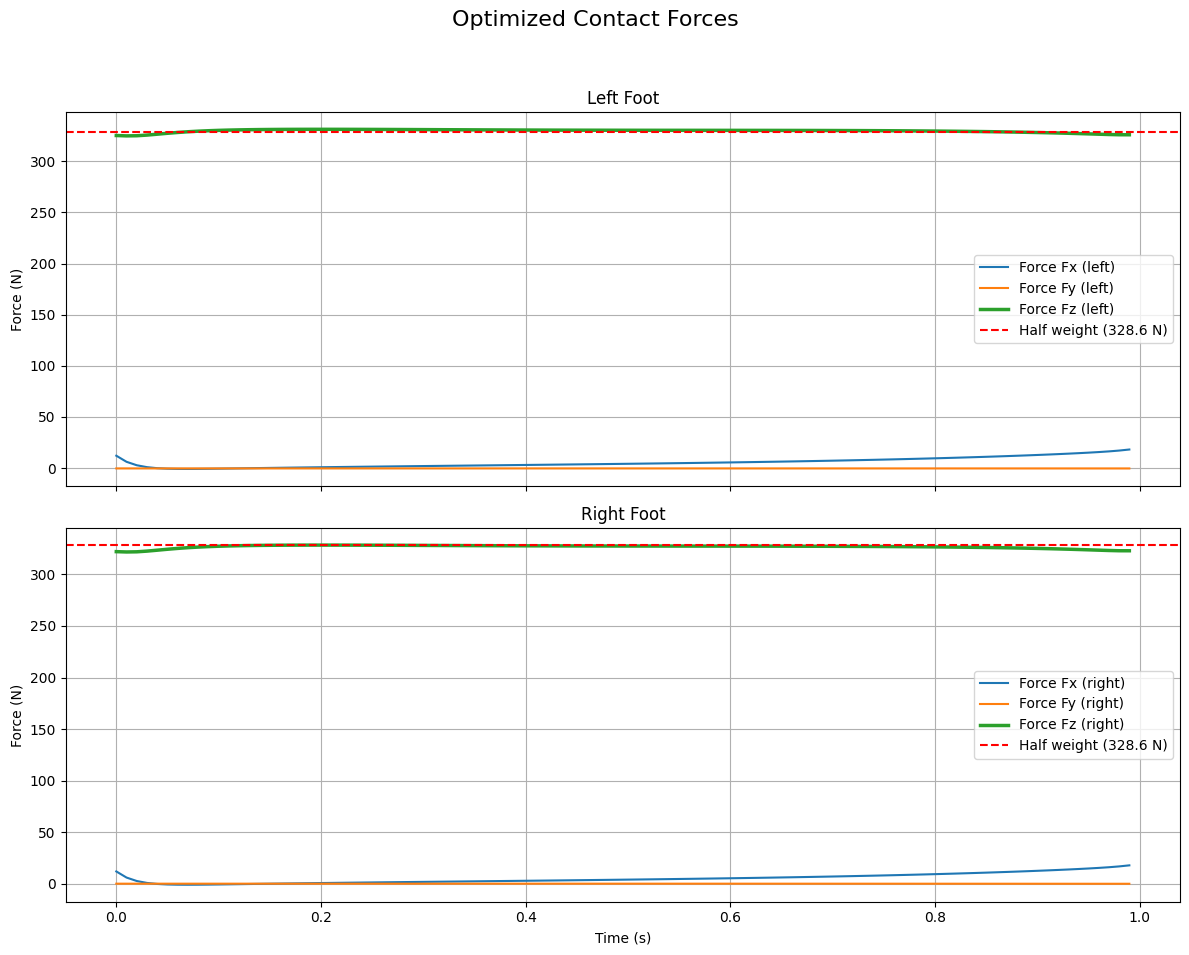

In [18]:
# PLOTS
import matplotlib.pyplot as plt
import numpy as np

xs_ref = []
# La trajectoire a HORIZON_LENGTH + 1 états (de 0 à T)
for i in range(HORIZON_LENGTH + 1):
    alpha = float(i) / HORIZON_LENGTH
    x_ref_i = (1 - alpha) * x0 + alpha * x_final
    xs_ref.append(x_ref_i)

# output from the solver
xs_res = solver.xs
us_res = solver.us

z_ref = [x[2] for x in xs_ref]
z_optimized = [x[2] for x in xs_res]
# Create the time axis for the plot
time_axis = np.arange(len(xs_init)) * TIME_STEP
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_axis, z_ref, 'o-', label="Initial Trajectory (xs_init)", color='gray', alpha=0.7)
plt.plot(time_axis, z_optimized, 'o-', label="Optimized Trajectory (solver.xs)", color='blue')
plt.title("Evolution of Robot Height (Z)")
plt.xlabel("Time (s)")
plt.ylabel("Z Position (m)")
plt.legend()
plt.grid(True)
plt.show()


# --- CONTACT FORCES EXTRACTION ---

# We retrieve data from each time step (except the terminal node)
running_datas = solver.problem.runningDatas

left_forces = []
right_forces = []

for data in running_datas:

    contact_datas = data.differential.multibody.contacts
    
    f_left = contact_datas.contacts['left_ground_contact'].f.vector
    f_right = contact_datas.contacts['right_ground_contact'].f.vector
    
    left_forces.append(f_left)
    right_forces.append(f_right)

left_forces = np.array(left_forces)
right_forces = np.array(right_forces)

time_axis_f = np.arange(len(left_forces)) * TIME_STEP


# --- DISPLAYING FORCES ---

# Creating a figure with two subplots (one for each foot)
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Optimized Contact Forces', fontsize=16)

# Graph for the left foot
axs[0].plot(time_axis_f, left_forces[:, 0], label="Force Fx (left)")
axs[0].plot(time_axis_f, left_forces[:, 1], label="Force Fy (left)")
axs[0].plot(time_axis_f, left_forces[:, 2], label="Force Fz (left)", linewidth=2.5)
axs[0].set_title("Left Foot")
axs[0].set_ylabel("Force (N)")
axs[0].grid(True)

# Graph for the right foot
axs[1].plot(time_axis_f, right_forces[:, 0], label="Force Fx (right)")
axs[1].plot(time_axis_f, right_forces[:, 1], label="Force Fy (right)")
axs[1].plot(time_axis_f, right_forces[:, 2], label="Force Fz (right)", linewidth=2.5)
axs[1].set_title("Right Foot")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Force (N)")
axs[1].grid(True)

# Display total robot weight as a reference
try:
    robot_weight = pin.computeTotalMass(model) * 9.81
    axs[0].axhline(y=robot_weight/2, color='r', linestyle='--', label=f'Half weight ({robot_weight/2:.1f} N)')
    axs[1].axhline(y=robot_weight/2, color='r', linestyle='--', label=f'Half weight ({robot_weight/2:.1f} N)')
except NameError:
    print("Variable 'q0' is not defined, unable to display robot weight.")

axs[0].legend()
axs[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [19]:
# Launch the simulation
import time
print("Starting animation...")

xs_opt = solver.xs
xs_opt_array = np.array(solver.xs)
q_trajectory = xs_opt_array[:, :model.nq]

for q in q_trajectory:

    # Send q to robot visualization
    robot_visualizer.display(q)

    # dt is TIME_STEP
    time.sleep(TIME_STEP)

print("\nAnimation end.")

Starting animation...

Animation end.
